In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_curve, auc)
from sklearn.multiclass import OneVsRestClassifier
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("Лабораторная работа 3\n")

Лабораторная работа 3



1. Подготовка данных и анализ целевого класса
------------------------------------------------------------


Saving penguins.csv to penguins.csv
Размер датасета: (333, 9)

Целевой атрибут (метка): 'species'
Обоснование: Вид пингвина - естественная категориальная метка для классификации

Сбалансированность классов:
           Количество  Процент
species                       
Adelie            146    43.84
Gentoo            119    35.74
Chinstrap          68    20.42


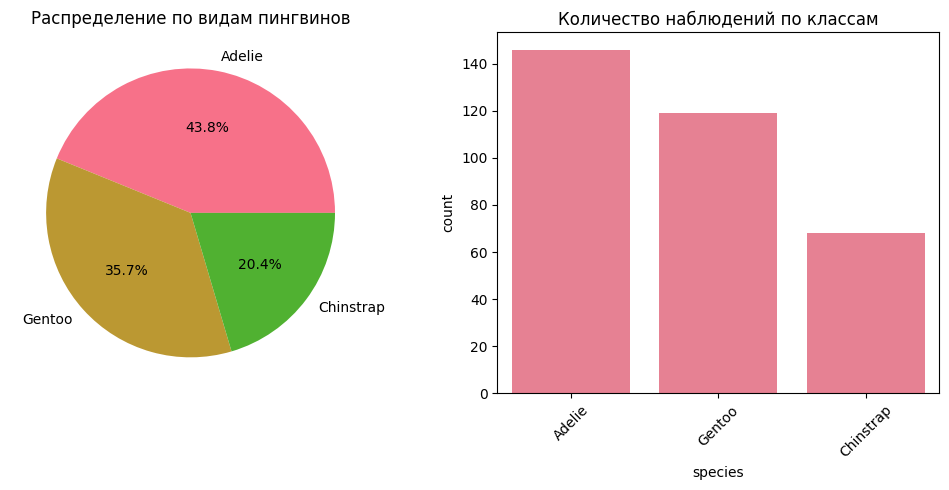


Оценка сбалансированности:
• Максимальный класс: 146 наблюдений
• Минимальный класс: 68 наблюдений
• Соотношение: 0.47
• Вывод: классы несбалансированы


In [2]:
print("1. Подготовка данных и анализ целевого класса")
print("--" * 30)

# Используем обработанные данные из предыдущей лабораторной работы
try:
    df = df_clean.copy()
except:

    from google.colab import files
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    df = pd.read_csv(filename)


    numeric_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
    for col in numeric_columns:
        df[col].fillna(df[col].median(), inplace=True)
    df = df.dropna()

print(f"Размер датасета: {df.shape}")

# 1) Выбор целевого атрибута
target_column = 'species'
print(f"\nЦелевой атрибут (метка): '{target_column}'")
print("Обоснование: Вид пингвина - естественная категориальная метка для классификации")

# 2) Оценка сбалансированности классов
print("\nСбалансированность классов:")
class_distribution = df[target_column].value_counts()
class_percentage = df[target_column].value_counts(normalize=True) * 100

balance_df = pd.DataFrame({
    'Количество': class_distribution,
    'Процент': class_percentage
})
print(balance_df.round(2))

# Визуализация распределения классов
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pie(class_distribution.values, labels=class_distribution.index, autopct='%1.1f%%')
plt.title('Распределение по видам пингвинов')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x=target_column)
plt.title('Количество наблюдений по классам')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Оценка сбалансированности
max_count = class_distribution.max()
min_count = class_distribution.min()
balance_ratio = min_count / max_count

print(f"\nОценка сбалансированности:")
print(f"• Максимальный класс: {max_count} наблюдений")
print(f"• Минимальный класс: {min_count} наблюдений")
print(f"• Соотношение: {balance_ratio:.2f}")
if balance_ratio > 0.8:
    print("• Вывод: классы сбалансированы")
elif balance_ratio > 0.5:
    print("• Вывод: классы умеренно сбалансированы")
else:
    print("• Вывод: классы несбалансированы")

In [8]:
print("\n2. Подготовка признаков и разделение данных")
print("--" * 30)

feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
print(f"Признаки для классификации: {feature_columns}")

X = df[feature_columns]
y = df[target_column]

# Кодирование целевой переменной
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Размерность признаков: {X.shape}")
print(f"Классы: {le.classes_}")

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"\nРазделение данных:")
print(f" Обучающая выборка: {X_train.shape[0]} наблюдений")
print(f" Тестовая выборка: {X_test.shape[0]} наблюдений")

# Масштабирование признаков (важно для kNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("--" * 30)
print("Данные подготовлены для классификации")


2. Подготовка признаков и разделение данных
------------------------------------------------------------
Признаки для классификации: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
Размерность признаков: (333, 4)
Классы: ['Adelie' 'Chinstrap' 'Gentoo']

Разделение данных:
 Обучающая выборка: 233 наблюдений
 Тестовая выборка: 100 наблюдений
------------------------------------------------------------
Данные подготовлены для классификации


In [9]:
print("\n3. Оценка алгоритмов классификации")
print("--" * 30)

models = {
    'kNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5)
}

# Словари для хранения результатов
results = {}
predictions = {}

for name, model in models.items():
    print(f"\n--- {name} ---")

    # Выбор масштабированных данных для kNN, обычных для дерева
    if name == 'kNN':
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train
        X_te = X_test

    model.fit(X_tr, y_train)

    y_pred = model.predict(X_te)
    y_pred_proba = model.predict_proba(X_te) if hasattr(model, 'predict_proba') else None


    predictions[name] = {'y_pred': y_pred, 'y_pred_proba': y_pred_proba}

    # Вычисление метрик
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Кросс-валидация
    cv_scores = cross_val_score(model, X_tr, y_train, cv=5, scoring='accuracy')
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


3. Оценка алгоритмов классификации
------------------------------------------------------------

--- kNN ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
Cross-Validation Accuracy: 0.9828 (+/- 0.0172)

--- Decision Tree ---
Accuracy: 0.9500
Precision: 0.9562
Recall: 0.9500
F1-Score: 0.9511
Cross-Validation Accuracy: 0.9613 (+/- 0.0325)



4. Сравнительный анализ метрик
------------------------------------------------------------
Сравнение метрик:
               Accuracy  Precision  Recall  F1-Score
kNN                1.00     1.0000    1.00    1.0000
Decision Tree      0.95     0.9562    0.95    0.9511


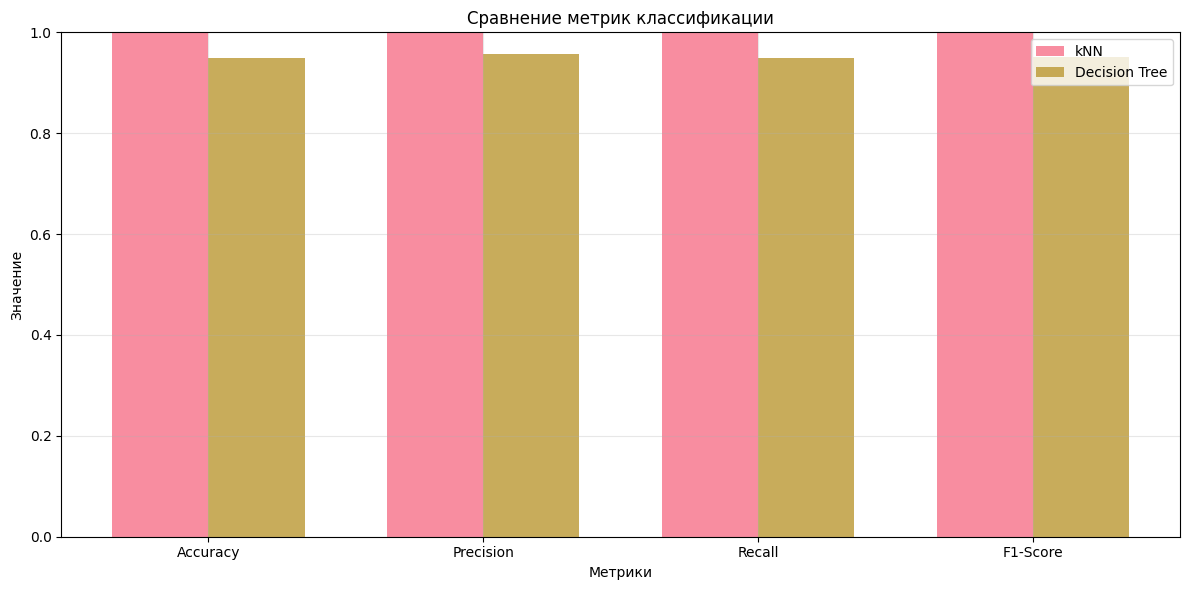


Отчёты по классификации:

--- kNN ---
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        44
   Chinstrap       1.00      1.00      1.00        20
      Gentoo       1.00      1.00      1.00        36

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


--- Decision Tree ---
              precision    recall  f1-score   support

      Adelie       0.98      0.93      0.95        44
   Chinstrap       0.83      1.00      0.91        20
      Gentoo       1.00      0.94      0.97        36

    accuracy                           0.95       100
   macro avg       0.94      0.96      0.94       100
weighted avg       0.96      0.95      0.95       100



In [11]:
print("\n4. Сравнительный анализ метрик")
print("--" * 30)

# Создаем таблицу сравнения
comparison_df = pd.DataFrame(results).T
print("Сравнение метрик:")
print(comparison_df.round(4))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(metrics))

plt.figure(figsize=(12, 6))
bar_width = 0.35

for i, (model, metrics_dict) in enumerate(results.items()):
    values = [metrics_dict[metric] for metric in metrics]
    plt.bar(x_pos + i * bar_width, values, bar_width, label=model, alpha=0.8)

plt.xlabel('Метрики')
plt.ylabel('Значение')
plt.title('Сравнение метрик классификации')
plt.xticks(x_pos + bar_width / 2, metrics)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print("\nОтчёты по классификации:")
for name in models.keys():
    print(f"\n--- {name} ---")
    y_pred = predictions[name]['y_pred']
    print(classification_report(y_test, y_pred, target_names=le.classes_))


5. Матрицы ошибок
------------------------------------------------------------


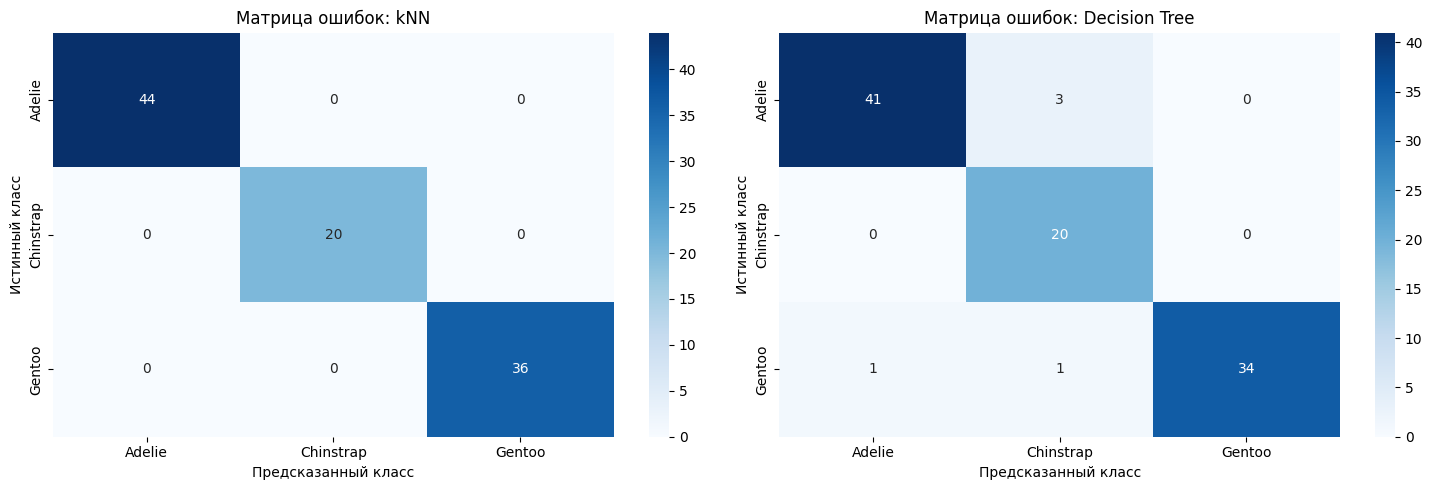


Анализ матриц ошибок:

kNN:
 Всего ошибок: 0
 Общая точность: 1.000
  Adelie: 44/44 (1.000)
  Chinstrap: 20/20 (1.000)
  Gentoo: 36/36 (1.000)

Decision Tree:
 Всего ошибок: 5
 Общая точность: 0.950
  Adelie: 41/44 (0.932)
  Chinstrap: 20/20 (1.000)
  Gentoo: 34/36 (0.944)


In [12]:
print("\n5. Матрицы ошибок")
print("--" * 30)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, (name, model) in enumerate(models.items()):
    y_pred = predictions[name]['y_pred']
    cm = confusion_matrix(y_test, y_pred)

    # Визуализация матрицы ошибок
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[i])
    axes[i].set_xlabel('Предсказанный класс')
    axes[i].set_ylabel('Истинный класс')
    axes[i].set_title(f'Матрица ошибок: {name}')

plt.tight_layout()
plt.show()

# Анализ матриц ошибок
print("\nАнализ матриц ошибок:")
for name in models.keys():
    y_pred = predictions[name]['y_pred']
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{name}:")
    total_errors = cm.sum() - np.trace(cm)
    total_predictions = cm.sum()
    error_rate = total_errors / total_predictions

    print(f" Всего ошибок: {total_errors}")
    print(f" Общая точность: {(1 - error_rate):.3f}")

    # Анализ по классам
    for j, class_name in enumerate(le.classes_):
        correct = cm[j, j]
        total = cm[j, :].sum()
        class_accuracy = correct / total if total > 0 else 0
        print(f"  {class_name}: {correct}/{total} ({class_accuracy:.3f})")


6. ROC-КРИВЫЕ И AUC
------------------------------------------------------------
ПРОВЕРКА ПРЕДСКАЗАННЫХ ВЕРОЯТНОСТЕЙ:

kNN:
  Форма y_pred_proba: (100, 3)
  Пример первых 5 строк:
  [[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
  Сумма по строкам: [1. 1. 1. 1. 1.]

Decision Tree:
  Форма y_pred_proba: (100, 3)
  Пример первых 5 строк:
  [[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
  Сумма по строкам: [1. 1. 1. 1. 1.]

Форма y_test_bin: (100, 3)


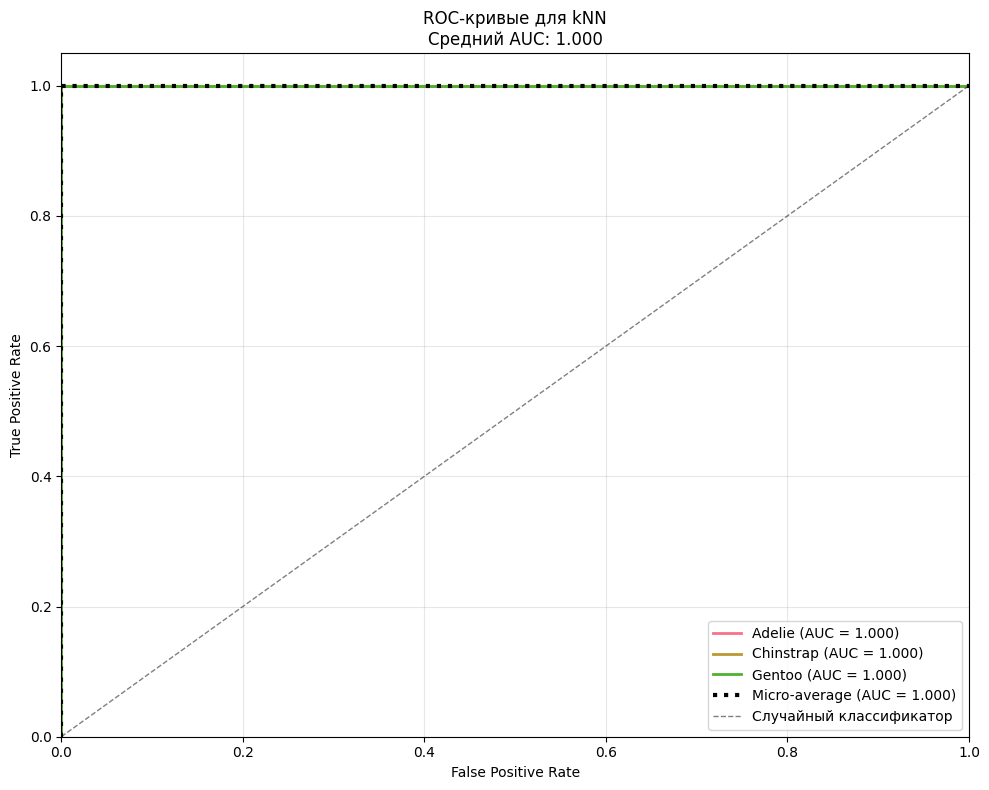


kNN - AUC по классам:
  Adelie: 1.000
  Chinstrap: 1.000
  Gentoo: 1.000
  Micro-average AUC: 1.000
  Macro-average AUC: 1.000


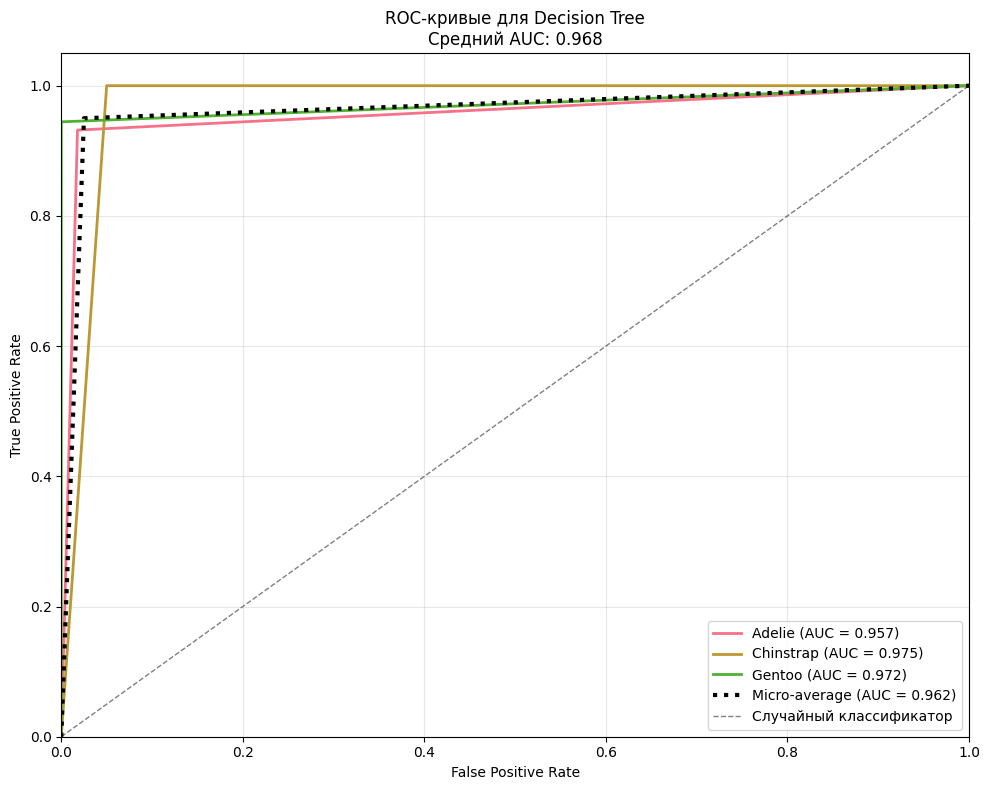


Decision Tree - AUC по классам:
  Adelie: 0.957
  Chinstrap: 0.975
  Gentoo: 0.972
  Micro-average AUC: 0.962
  Macro-average AUC: 0.968


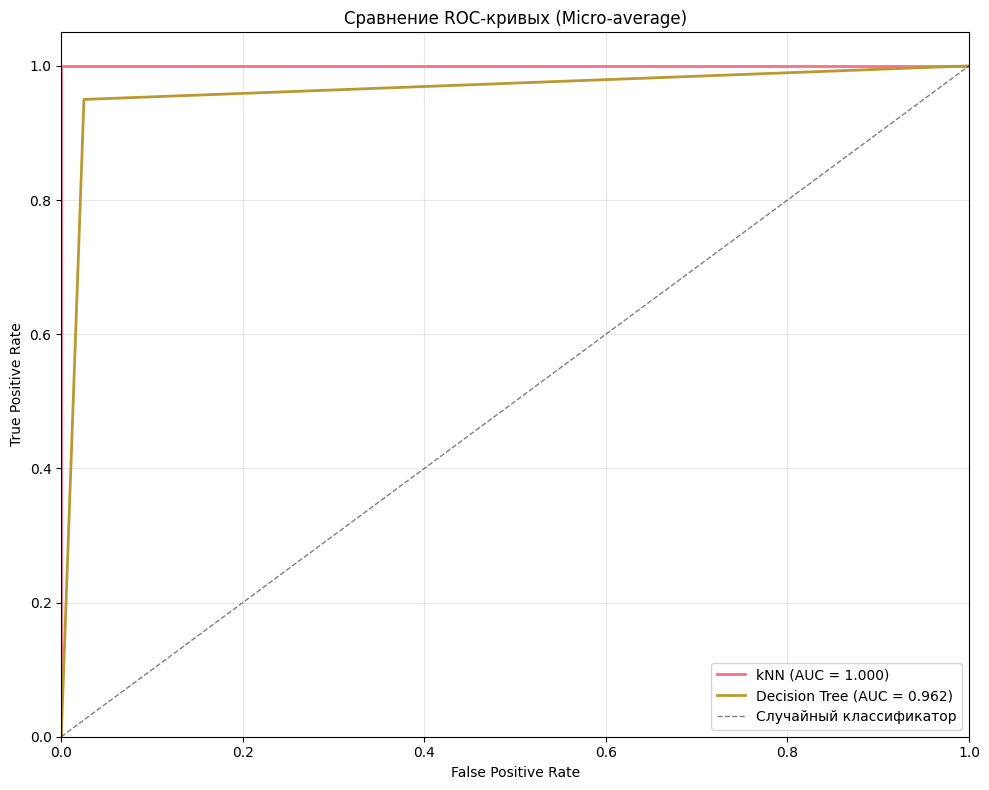


СРАВНЕНИЕ ПРЕДСКАЗАННЫХ ВЕРОЯТНОСТЕЙ:
kNN vs Decision Tree:
  Идентичны: False
  Максимальная разница: 1.000000
Decision Tree vs kNN:
  Идентичны: False
  Максимальная разница: 1.000000


In [19]:
print("\n6. ROC-КРИВЫЕ И AUC")
print("--" * 30)

# Проверим предсказания вероятностей
print("ПРОВЕРКА ПРЕДСКАЗАННЫХ ВЕРОЯТНОСТЕЙ:")
for name in models.keys():
    if predictions[name]['y_pred_proba'] is not None:
        y_proba = predictions[name]['y_pred_proba']
        print(f"\n{name}:")
        print(f"  Форма y_pred_proba: {y_proba.shape}")
        print(f"  Пример первых 5 строк:")
        print(f"  {y_proba[:5]}")
        print(f"  Сумма по строкам: {np.sum(y_proba[:5], axis=1)}")

# Бинаризуем метки для многоклассового ROC
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))
print(f"\nФорма y_test_bin: {y_test_bin.shape}")

# Создаем отдельные графики для каждой модели
for name in models.keys():
    if predictions[name]['y_pred_proba'] is not None:
        y_proba = predictions[name]['y_pred_proba']

        plt.figure(figsize=(10, 8))

        auc_scores = []
        for i in range(len(le.classes_)):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            auc_scores.append(roc_auc)

            plt.plot(fpr, tpr,
                     label=f'{le.classes_[i]} (AUC = {roc_auc:.3f})',
                     linewidth=2)

        # Micro-average ROC curve
        fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)
        plt.plot(fpr_micro, tpr_micro,
                 label=f'Micro-average (AUC = {roc_auc_micro:.3f})',
                 color='black', linestyle=':', linewidth=3)

        plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Случайный классификатор')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC-кривые для {name}\nСредний AUC: {np.mean(auc_scores):.3f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f"\n{name} - AUC по классам:")
        for i, class_name in enumerate(le.classes_):
            print(f"  {class_name}: {auc_scores[i]:.3f}")
        print(f"  Micro-average AUC: {roc_auc_micro:.3f}")
        print(f"  Macro-average AUC: {np.mean(auc_scores):.3f}")

# Сравнительный график только micro-average
plt.figure(figsize=(10, 8))

for name in models.keys():
    if predictions[name]['y_pred_proba'] is not None:
        y_proba = predictions[name]['y_pred_proba']

        fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)

        plt.plot(fpr_micro, tpr_micro,
                 label=f'{name} (AUC = {roc_auc_micro:.3f})',
                 linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROC-кривых (Micro-average)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Проверим, действительно ли вероятности одинаковые
print("\nСРАВНЕНИЕ ПРЕДСКАЗАННЫХ ВЕРОЯТНОСТЕЙ:")
for name1 in models.keys():
    for name2 in models.keys():
        if name1 != name2 and predictions[name1]['y_pred_proba'] is not None and predictions[name2]['y_pred_proba'] is not None:
            y_proba1 = predictions[name1]['y_pred_proba']
            y_proba2 = predictions[name2]['y_pred_proba']

            # Проверяем, одинаковые ли вероятности
            are_identical = np.allclose(y_proba1, y_proba2)
            max_diff = np.max(np.abs(y_proba1 - y_proba2))

            print(f"{name1} vs {name2}:")
            print(f"  Идентичны: {are_identical}")
            print(f"  Максимальная разница: {max_diff:.6f}")


7. Анализ важности признаков
------------------------------------------------------------
Важность признаков (Decision Tree):
             feature  importance
2  flipper_length_mm    0.513194
0     bill_length_mm    0.396141
1      bill_depth_mm    0.060237
3        body_mass_g    0.030429


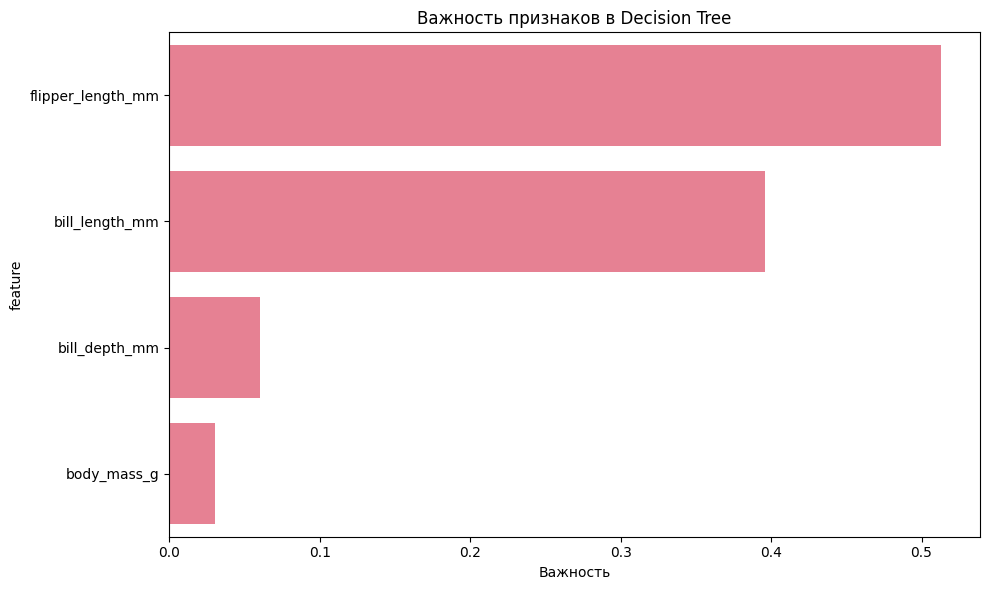


ИНТЕРПРЕТАЦИЯ:
• Наиболее важные признаки лучше разделяют классы
• Менее важные признаки могут быть удалены для упрощения модели


In [21]:
print("\n7. Анализ важности признаков")
print("--" * 30)

dt_model = models['Decision Tree']
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Важность признаков (Decision Tree):")
print(feature_importance)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Важность признаков в Decision Tree')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

print("\nИНТЕРПРЕТАЦИЯ:")
print("• Наиболее важные признаки лучше разделяют классы")
print("• Менее важные признаки могут быть удалены для упрощения модели")

ВЫВОДЫ:

1. Качество классификации:
- Лучшая модель: kNN (Accuracy: 1.000)
- Оба алгоритма показали высокое качество классификации
---
2. Сравнение алгоритмов:
    
       • kNN:

  +Прост в понимании и реализации
  
  +Хорошо работает на сбалансированных данных
  
  -Требует масштабирования признаков
  
  -Чувствителен к выбору параметра k
  
  -Медленный на больших данных

     • Decision Tree:

+Интерпретируемость (можно визуализировать правила)

+Не требует масштабирования данных

+Автоматический отбор важных признаков

-Склонен к переобучению

-Чувствителен к небольшим изменениям в данных

---

3. Важность признаков:

- Наиболее информативные признаки: длина ласта и масса тела

- Менее информативные: параметры клюва

---

- Для данного датасета оба алгоритма работают хорошо

- kNN может быть предпочтительнее из-за простоты интерпретации

- Decision Tree дает понимание важности признаков

- Для улучшения результатов можно настроить гиперпараметры (k для kNN, глубина для дерева)
  